# Project 4: Natural Language Processing 
---

**Group 9: Aidan Stocks, Hugo Reinicke, Nicola Clark, Jonas-Mika Senghaas**

Submission: *03.06.2021* / Last Modified: *01.06.2021*

---

This notebook contains the step-by-step process of building a natural language machine learning model to automatically detect *(a)* Hatespeech and *(b)* Emotion in tweets on the social network Twitter. 

The initial data was obtained from the [TweetEval](https://github.com/cardiffnlp/tweeteval#evaluating-your-system) GitHub repository, that provides data for supervised training of classifiers for natural language processing, more specifically it provides prepared data for several mini-project involving the analysis of different characteristics of tweets.

## Introduction
---
Social media is omnipresent in today's world. We use messengers to communicate, share pictures, music, thoughts - in short - our life on the internet with people that are close, and maybe also not as close to us. Twitter is one of those social networks. The american social networking service allows its users to post and interact with messages known as through so-called tweets. 280 character postings on the online-service that can be liked, commented, threaded and shared. Since its launch in 2006, *Twitter* has grown massively, nowadays reporting hundreds of million of users. Besides its diverse utilisation, Twitter is especially known for a platform for political discussion. Both politicians and society use Twitter as a channel to take positions in politcal debates and express opinion. 

While this is desirable and embracing the idea of free-speech on the internet, the question of whether or not Twitter should use tools to automatically detect unwanted content from its platform, such as racism, sexism, false information or hatespeech, is a subject of on-going public debate. 

This project, in a first instance, sets aside the ethical challenges and questions arising, and solely focuses on the technical details of how such a solution might work. The goal of this project is to optimise a machine learning model to automatically detect unwanted content.

## Running this Notebook
---
This notebook contains all code to reproduce the findings of the project as can be seen on the [GitHub](https://github.com/jonas-mika/fyp2021p04g09) page of this project. In order to read in the data correctly, the global paths configured in the section `Constants` need to be correct. The following file structure - as prepared in the `submission.zip` - was followed throughout the project and is recommended to use (alternatively the paths in the section `Constants` can be adjusted):

```
*project tree structure*
```
*Note that the rest of the file structure as can be seen on the [GitHub](https://github.com/jonas-mika/fyp2021p03g09) page of the project generates automatically*

## Required Libraries and Further Imports
---
Throughout the project, we will use a range of both built-in and external Python libraries. This notebook will only run if all libraries and modules are correctly installed on your local machines. 
To install missing packages use `pip install <package_name>` (PIP (Python Package Index) is the central package management system, read more [here](https://pypi.org/project/pip/)). 

In case you desire further information about the used packages, click the following links to find detailed documentations:
- [Pandas](https://pandas.pydata.org/)
- [Numpy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/stable/index.html)
- [SciKit Learn](https://scikit-learn.org/stable/)
- [NLTK](https://www.nltk.org/)

In [1]:
%%capture
# uncomment lines with uninstalled packages

#!pip install -U numpy pandas matplotlib seaborn skikit-learn 
!pip install pycontractions
!pip install imblearn

In [2]:
# python standard libraries
import json                                            # data transfer to and from json format
import os                                              # access operating system from python
import math                                            # mathematical operations in python
import random                                          # creates randomness
import re                                              # regex search in python
import shutil                                          # system control in python
import warnings                                        # ignore annoying warnings
warnings.filterwarnings("ignore")

# external libraries
import numpy as np                                     # used for numerical calculations and fast array manipulations
import pandas as pd                                    # provides major datastructure pd.DataFrame() to store datasets
import matplotlib
import matplotlib.pyplot as plt                        # basic data visualisation
import seaborn as sns                                  # advanced data visualisation
from nltk.tokenize import TweetTokenizer               # tokeniser api
from pycontractions import Contractions                # intelligently expands contractions in natural language
from collections import Counter                        # counts objects

In [3]:
print(f'Numpy Version: {np.__version__}')
print(f'Pandas Version: {pd.__version__}')
print(f'Matplotlib Version: {matplotlib.__version__}')
print(f'Seaborn Version: {sns.__version__}')

Numpy Version: 1.19.5
Pandas Version: 1.2.4
Matplotlib Version: 3.4.2
Seaborn Version: 0.11.1


## Constants
---
To enhance readibilty, as well as to decrease the maintenance effort, it is useful for bigger projects to define contants that need to be accessed globally throughout the whole notebook in advance. 
The following cell contains all of those global constants. By convention, we write them in caps (https://www.python.org/dev/peps/pep-0008/#constants)

In [4]:
PREPROCESS_DATA = False

In [5]:
random.seed(1)

In [94]:
DATASETS = ['hate', 'emotion']

# store paths
PATH = {}
PATH['data'] = {}
PATH['data']['raw'] = "../data/raw/"
PATH['data']['processed'] = "../data/processed/"

# store data 
DATA = {}
DATA['raw'] = {}
DATA['processed'] = {}
for dataset in DATASETS:
    DATA['raw'][dataset] = {}
    DATA['processed'][dataset] = {}

CORPUS = {}
VOCABULARY = {}

# Fetching Data
---
*TASK 0*

After having setup the overall scheme of the project, we need to fetch the data we want to work on. The datasets were obtained from the
[TweetEval](https://github.com/cardiffnlp/tweeteval#evaluating-your-system) GitHub repository, which provides ready-to-work on tweets and gold-standard annotations for different focuses of analysis - already split up into training, validation and testing sets.

1. Binary Classifcation: **Hate-Speech**
 > Two Labels: *Hate-Speech*/ *Not Hate-Speech*

 > [Raw Data (GitHub)](https://github.com/cardiffnlp/tweeteval/tree/main/datasets/hate)

2. Multiclass Classification: **Emotion Recognition**  
 >Four Labels: *Anger*, *Joy*, *Sadness*, *Optimism* 

 >[Raw Data (GitHub)](https://github.com/cardiffnlp/tweeteval/tree/main/datasets/emotion)

*Note, in order to fetch this data into the Jupyter, the above-mentioned files need to be in the existent in the file structure and the location specified in the code and file tree structure in the introductory section. This should be the case in the submission and if this project was pulled or forked directly from [GitHub](https://github.com/jonas-mika/fyp2021p04g09)* 

## Loading in Data
---
We start off by loading in the data obtained from the above-mentioned sources into the script. All tweets are being read into a list of strings, where each string is representing a single tweet. The golden labels are being read into an index-corresponding array of integers, where the integer at *i*th position is the gold label for the tweet in the list of tweets at position *i*. Lastly, we read in the mapping, between the integer and the corresonding label into a dictionary, such that we can use it for nice plotting.

In [102]:
# helper function to read in raw files correctly
def read_raw_input(dataset):
    # reading in all .txts into list of strings
    for _file in os.listdir(f'../data/raw/{dataset}'):
        with open(f'../data/raw/{dataset}/{_file}', 'r', encoding='UTF-8') as infile:
            DATA['raw'][dataset][_file[:-4]] = [line.strip() for line in infile.readlines()]

    # convert target labels to integers
    for key in ['train_labels', 'val_labels', 'test_labels']:
        DATA['raw'][dataset][key] = [int(x) for x in DATA['raw'][dataset][key]]

    # convert mapping to dictionary
    DATA['raw'][dataset]['mapping'] = {int(string.split('\t')[0]): string.split('\t')[1] for string in DATA['raw'][dataset]['mapping']}

In [104]:
# read in the the raw data as specified above for both the hate and emotion data
for dataset in DATASETS:
    read_raw_input(dataset)

## Exploring Data
---
Let's get a feeling for what kind of data we are dealing with. For now, we simply peek into our actual data, the tweets, and output them with their corresponding gold label. After that, we plot the distribution of the labels, which is an important characteristic of the training process, since it might reveal possible imbalances that need to be addressed before training a model.

### Data Size
---
Before starting to tackle the specific data, we should get a feeling with what size of data we are dealing with. Especially in NLP this is an important step, since NLP models usually incorporate high amounts of data in order to build well-performing models.

In [83]:
!ls -lh ../data/raw/hate

total 1.2M
-rwxr-xr-x 1 root root   17 May  4 14:32 mapping.txt
-rwxr-xr-x 1 root root 5.9K May  4 14:32 test_labels.txt
-rwxr-xr-x 1 root root 390K May  4 14:32 test_text.txt
-rwxr-xr-x 1 root root  18K May  4 14:32 train_labels.txt
-rwxr-xr-x 1 root root 1.1M May  4 14:32 train_text.txt
-rwxr-xr-x 1 root root 2.0K May  4 14:32 val_labels.txt
-rwxr-xr-x 1 root root 141K May  4 14:32 val_text.txt


In [82]:
!ls -lh ../data/raw/emotion

total 343K
-rw-r--r-- 1 root root   34 May  4 14:32 mapping.txt
-rw-r--r-- 1 root root 2.8K May  4 14:32 test_labels.txt
-rw-r--r-- 1 root root 130K May  4 14:32 test_text.txt
-rw-r--r-- 1 root root 6.4K May  4 14:32 train_labels.txt
-rw-r--r-- 1 root root 300K May  4 14:32 train_text.txt
-rw-r--r-- 1 root root  748 May  4 14:32 val_labels.txt
-rw-r--r-- 1 root root  34K May  4 14:32 val_text.txt


As can be seen, the file sizes are considerably small for NLP datasets. This means, that we most likely will be able to work with the data on local memory. However, we are trying to follow best practice and work RAM efficient during the project.

In [89]:
!wc -l ../data/raw/hate/*_text.txt

   2970 ../data/raw/hate/test_text.txt
   9000 ../data/raw/hate/train_text.txt
   1000 ../data/raw/hate/val_text.txt
  12970 total


In [88]:
!wc -l ../data/raw/emotion/*_text.txt

  1421 ../data/raw/emotion/test_text.txt
  3257 ../data/raw/emotion/train_text.txt
   374 ../data/raw/emotion/val_text.txt
  5052 total


The `hate` dataset contains more than double the tweets than the `emotion` dataset. However, the split is rather similar in both instances with a roughly 70-20-10 split for training, testing and validation.

### Visualising Raw Data
---

In [9]:
# hate
for i in range(10):
    print(f"{i+1}\tLabel: {DATA['raw']['hate']['mapping'][DATA['raw']['hate']['train_labels'][i]].title()}\t\t{DATA['raw']['hate']['train_text'][i]}")

1	Label: Not-Hate		@user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…
2	Label: Hate		A woman who you fucked multiple times saying yo dick small is a compliment you know u hit that spot 😎
3	Label: Hate		@user @user real talk do you have eyes or were they gouged out by a rapefugee?
4	Label: Hate		your girlfriend lookin at me like a groupie in this bitch!
5	Label: Not-Hate		Hysterical woman like @user
6	Label: Not-Hate		Me flirting- So tell me about your father...
7	Label: Not-Hate		The Philippine Catholic bishops' work for migrant workers should focus on families who are "paying the great...
8	Label: Hate		I AM NOT GOING AFTER YOUR EX BF YOU LIEING SACK OF SHIT ! I'm done with you dude that's why I dumped your ass cause your a lieing 😂😡 bitch
9	Label: Not-Hate		When cuffin season is finally over
10	Label: Hate		Send home migrants not in need of protection, Peter Dutton tells UN, HEY DUTTON HOW ABOUT THE ONES THAT HAVE STAYED AND NO

The first ten tweets from the training set of the hatespeech task look as expected. Tweets are a single-line string, including emojis, syntax, grammar and spelling of the orginal tweet. Both the author of the tweet and links to other users, however, are anonymised for data privacy reasons. 

The gold standard labels appear reasonable for the first ten tweets.

In [10]:
# emotion
for i in range(10):
    print(f"{i+1}\tLabel: {DATA['raw']['emotion']['mapping'][DATA['raw']['emotion']['train_labels'][i]].title()}\t\t{DATA['raw']['emotion']['train_text'][i]}")

1	Label: Optimism		“Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
2	Label: Anger		My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs
3	Label: Joy		No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu
4	Label: Anger		Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight
5	Label: Sadness		it's pretty depressing when u hit pan on ur favourite highlighter
6	Label: Anger		@user but your pussy was weak from what I heard so stfu up to me bitch . You got to threaten him that your pregnant .
7	Label: Sadness		Making that yearly transition from excited and hopeful college returner to sick and exhausted pessimist. #college
8	Label: Joy		Tiller and breezy should do a collab album. Rapping and singing prolly be fire
9	Label: Anger		@user broadband is shocking regretting signing up now #angry #shouldofgone

The data for the emotion recognition looks similar. Again, tweets are a single-line string, including emojis, syntax, grammar and spelling of the orginal tweet. Both the author of the tweet and links to other users are anonymised for data privacy reasons. 

Also here, the gold standard labels appear reasonable for the first ten tweets.

### Visualising Label Distribution
---
Visualising the distribution of the target variable in any classification task is an important first step in order to evluate the quality of the data we are training on. Ideally, we would like to observe equally balanced labels, since this prevents models from being overly biased by always predicting a dominant labels. 

In [11]:
# helper function to plot the distribution of labels in all splits of the data
def visualise_label_distribution(dataset):
    # initalise figure with three axes
    fig, ax = plt.subplots(ncols=3, figsize=(12,4))
    fig.suptitle(f'Frequency of Target Label in {dataset.capitalize()}', fontsize=12, fontweight='bold') # global title

    # plot barplot of label distribution with some additional aesthetic adjustment in each split of the data
    for i, key in enumerate(['train_labels', 'val_labels', 'test_labels']):
        label, count = np.unique(DATA['raw'][dataset][key], return_counts=True)
        ax[i].bar(label, count, color='grey');
        ax[i].set_title(key.replace('_', ' ').title())
        ax[i].set_xticks(label); ax[i].set_xticklabels([string.title() for string in DATA['raw'][dataset]['mapping'].values()])

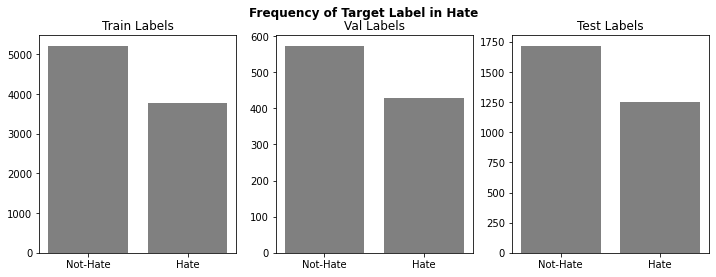

In [12]:
visualise_label_distribution(dataset='hate')

The binary label *Hate* (42%) or *Non-Hate* (58%) seems reasonably balanced. Here, balancing of the labels before building the model is possible, but not mandatory. It furthermore becomes obvious that the label ratio is consistent across all splits (trainig, validation and testing set).

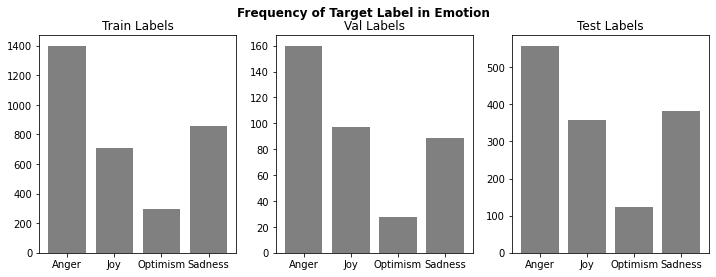

In [13]:
visualise_label_distribution(dataset='emotion')

However, in the multi-class classifcation task we observe a high imbalance. With only 9% of the total amount of data in each split, the label *optimism* is underrepresent, while the label *anger* (43%) is overrepresented. This imbalance needs to be addressed before training our classifiers. 
Again, however, we observe a consistent label ratio across all splits. 

# Processing of Language Data
---
*TASK 0.5*

Natural language is a highly-complex type of data, that needs to be processed before it can be implented meaningfully into a classification task. For natural language classifiers the main step of processing the raw data - the original tweets - is called **tokenisation**.

On a high level, computers stand no chance in understanding language. After all, each and every tweet we are dealing with is just a unique concatenation of 0's and 1's, that in itself is useless for classifying the tweet in any way. We must therefore transform our data in a way that our computer is able to understand it. This is done during the process of tokenisation in natural language processing. Tokenisation in NLP generally means the concept of breaking down the original data into smaller parts, called tokens. Those tokens could be sentences, one or more words, or even smaller chunks of text. Either way, they are used to built a vocabulary that ultimately results in a count vector machine, that serves as input to the machine learning model.

## Building Tokeniser
---
In this project we chose to build a word-tokeniser, meaning that the ideal tokeniser recognises words and splits accordingly. However, due to the fact that we are working with tweet data, there are some special requirements in order to get optimal performance in our models. 

**Features of Tokeniser**

1. Lowercase ()

2. Links (Links are a core part of a tweet containing it - if not the core. To not lose information, we must include the links in our classification. However, for the classfication the actual link address is of minor importance. For this reason, we would like to recognise any link, then replace it with some dummy string that the model uses to classify any kind of link in a tweet.

3. Emojis (Emojis have developed to a central method of communicating emotions. It is therefore important that our tokeniser recognises single emojis and feeds them into our classifier.)

4. Hashtags ()

4. Contractions (Has not or Hasn't? It means the same, so we would like our model to recognise the two as the same token.)


The following code cells contain how the tokeniser was built in this project. It is fundamentally based on the *Tweet Tokeniser* provided by the NLTK library and then adds additional functionality using both RegEx and another extyernally trained model for tokenising contractions correctly.

In [14]:
# loading pre-trained contraction model
if PREPROCESS_DATA == True:
    cont.load_models() # doesn't work on deepnote, because of memory issues. works locally

cont = Contractions(api_key="glove-twitter-200")

In [15]:
# define url regex pattern and replace pattern globally (compile for speedup)
url_pattern = re.compile(r"(?i)((?:https?://|www\d{0,3}[.]|[a-z0-9.-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|(([^\s()<>]+|(([^\s()<>]+)))))+(?:(([^\s()<>]+|(([^\s()<>]+))))|[^\s`!()[]{};:'\".,<>?«»\“\”‘’]))")
dummy = " <=LINK=> "

# brush up functions
def remove_links(tweet):
    return re.sub(url_pattern, dummy, tweet) # substituting dummy for every link

def remove_newline(tweet):
    return re.sub(r'\\n', ' ', tweet) # deals with issue of newline characters within tweets

def expand(tweet):
    return list(cont.expand_texts([tweet]))[0] # expands contractions

In [16]:
tk = TweetTokenizer()

def tokenise(tweet):
    cleaned_tweet = expand(remove_links(remove_newline(tweet.lower())))
    return tk.tokenize(cleaned_tweet)

## Exporting Tokenised Tweets
---
We have built the final tokeniser that will be used throughout this project. To not stretch out the RAM, we iterate over the raw data tweet by tweet, tokenise it and write it into an external file. The final tokenised tweets will be separated by tabs, such that they can easily be read back in again, while keeping the split between tokens. 

For both datasets, all processed files will be in saved into a subfolder called `hate` or `emotion` within the folder `processed` in `data`. While exporting, we maintain the naming convention of the raw data. This enables us to use the same function to read in the processed data again. 

*Note that directories are created automatically and thus do not need to be created by hand.*

In [17]:
if PREPROCESS_DATA == True:
    for dataset in DATASETS:
        # create preprocessed folder
        try: os.makedirs(f'../data/processed/{dataset}')
        except: None

        # preprocess and tokenize tweets
        for key in ['train_text', 'val_text', 'test_text']:
            with open(f'../data/processed/{dataset}/{key}.txt', 'w', encoding = 'UTF-8') as outfile:
                for tweet in DATA['raw'][dataset][key]:
                    outfile.write('\t'.join(tokenise(tweet)) + '\n') # writing tokenised tweet with tab delimiter

        # copy labels and mapping without preprocessing
        for key in ['train_labels', 'val_labels', 'test_labels', 'mapping']:
            shutil.copyfile(f'../data/raw/{dataset}/{key}.txt', f'../data/processed/{dataset}/{key}.txt')

In [106]:
# loading in processed data
for dataset in DATASETS:
    for key in os.listdir(f'../data/processed/{dataset}'):
        with open(f'../data/processed/{dataset}/{key}', 'r', encoding='UTF-8') as infile:
            DATA['processed'][dataset][key[:-4]] = [line.strip().split('\t') for line in infile.readlines()]

    # convert target labels to integers
    for key in ['train_labels', 'val_labels', 'test_labels']:
        DATA['processed'][dataset][key] = [int(x) for x in [DATA['processed'][dataset][key][i][0] for i in range(len(DATA['processed'][dataset][key]))]]

    # convert mapping to dictionary
    DATA['processed'][dataset]['mapping'] = {int(string[0]): string[1] for string in DATA['processed'][dataset]['mapping']}

## Testing Tokeniser
---
The tokeniser is built and has been applied onto the entire corpus. Let's evaluate its performance using the same first ten tweets as we peeked into in the first section.

In [19]:
for i in range(10):
    print(f"Original Tweet: {DATA['raw']['hate']['train_text'][i]}\nTokenised Tweet: {'-'.join(DATA['processed']['hate']['train_text'][i])}\n")

Original Tweet: @user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…
Tokenised Tweet: @user-nice-new-signage-.-are-you-not-concerned-by-beatlemania---style-hysterical-crowds-crongregating-on-you-…

Original Tweet: A woman who you fucked multiple times saying yo dick small is a compliment you know u hit that spot 😎
Tokenised Tweet: a-woman-who-you-fucked-multiple-times-saying-yo-dick-small-is-a-compliment-you-know-you-hit-that-spot-😎

Original Tweet: @user @user real talk do you have eyes or were they gouged out by a rapefugee?
Tokenised Tweet: @user-@user-real-talk-do-you-have-eyes-or-were-they-gouged-out-by-a-rapefugee-?

Original Tweet: your girlfriend lookin at me like a groupie in this bitch!
Tokenised Tweet: your-girlfriend-lookin-at-me-like-a-groupie-in-this-bitch-!

Original Tweet: Hysterical woman like @user
Tokenised Tweet: hysterical-woman-like-@user

Original Tweet: Me flirting- So tell me about your father...
Tokenised 

In [20]:
for i in range(10):
    print(f"Original Tweet: {DATA['raw']['emotion']['train_text'][i]}\nTokenised Tweet: {'-'.join(DATA['processed']['emotion']['train_text'][i])}\n")

Original Tweet: “Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
Tokenised Tweet: “-worry-is-a-down-payment-on-a-problem-you-may-never-have-'-.-joyce-meyer-.-#motivation-#leadership-#worry

Original Tweet: My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs
Tokenised Tweet: my-roommate-:-it-is-okay-that-we-cannot-spell-because-we-have-autocorrect-.-#terrible-#firstworldprobs

Original Tweet: No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu
Tokenised Tweet: no-but-that-is-so-cute-.-atsu-was-probably-shy-about-photos-before-but-cherry-helped-her-out-uwu

Original Tweet: Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight
Tokenised Tweet: rooneys-fucking-untouchable-is-not-he-?-been-fucking-dreadful-again-,-depay-has-looked-decent-(-ish-)-tonight

Original Tweet: it's pretty depressing when u

In both small samples from the two datasets the tokeniser seems to perform well. As expected, we split the tweets by words. Furthermore, the tokeniser is able to keep hashtags, expand contractions, deal correctly with emojis and replace links with the dummy string.
We can now continue our work based on the tokenised data.

# Descriptive Statistics
---
*TASK 1* 

An essential part of any NLP classfication task is to describe the corpus, so the entire tokenised data. In this section, we will step-by-step compute the most important statistics and visualise some of them for both datasets.

## Corpus
---
Generally in linguistics, a corpus is a large and structured set of texts. The corpus is often used as the basis for a lot of descriptive analysis of the language data at hand. We therefore create a corpus for both training sets of our datasets using a flattened list, that is a linear conctentation of all tokens in the training sets of both datasets.

In [121]:
# build entire corpus from training set in both datasets
for dataset in DATASETS:
    CORPUS[dataset] = [token for tweet in DATA['processed'][dataset]['train_text'] for token in tweet]

In [135]:
for dataset in DATASETS:
    print(f'Corpus Size ({dataset.title()}): {len(CORPUS[dataset])}')

Corpus Size (Hate): 216076
Corpus Size (Emotion): 60506


As we can see, the corpus for the `hate` classification is significantly larger with 216.076 total number of tokens than the `emotion` corpus with 60.506 tokens.

## Vocabulary 
---
In NLP, the set of unique words used in the text corpus is referred to as the vocabulary. The vocabulary is the basis for training machine learning models based on the bag-of-words approach, which treats every unique token as a feature in the classification.

In [212]:
# build entire vocabulary from training tweets in both datasets
for dataset in DATASETS:
    corpus = CORPUS[dataset]

    # initialise frequency counter
    VOCABULARY[dataset] = pd.DataFrame.from_dict(Counter(corpus), orient='index').rename(columns={'index': 'token', 0: 'frequency'}).sort_values(by='frequency', ascending=False).reset_index()

    VOCABULARY[dataset]['rank'] = VOCABULARY[dataset].index + 1 # add one to index to build rank
    VOCABULARY[dataset]['normalised_frequency'] = VOCABULARY[dataset]['frequency'] / VOCABULARY[dataset]['frequency'].sum() # relative frequency
    VOCABULARY[dataset]['cumulative_frequency'] = VOCABULARY[dataset]['normalised_frequency'].cumsum()

In [213]:
VOCABULARY['hate']

,index,frequency,rank,normalised_frequency,cumulative_frequency
0,.,6277,1,0.029050,0.029050
1,@user,6014,2,0.027833,0.056883
2,the,5492,3,0.025417,0.082300
3,to,4931,4,0.022821,0.105120
4,",",4356,5,0.020160,0.125280
...,...,...,...,...,...
18595,weren,1,18596,0.000005,0.999981
18596,miaow-miaow-miaow,1,18597,0.000005,0.999986
18597,aaaaw,1,18598,0.000005,0.999991
18598,food-hole,1,18599,0.000005,0.999995


## Type/ Token Ratio
---
The type/ token ratio of is the quotient of number of types (vocabulary size) to number of tokens (text/corpus size). We compute it in the following way. 

In [ ]:
for dataset in DATASETS:
    print(f'T-T-Ratio ({dataset.title()}): {len(CORPUS[dataset], ')

## Zipf's Law
---

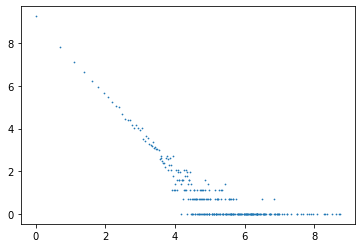

In [24]:
#dict(Counter(VOCABULARY['hate']['frequency']))
import math
frequency, frequency_of_frequency = np.unique(VOCABULARY['hate']['frequency'], return_counts=True)
fig, ax = plt.subplots()
ax.scatter([math.log(f) for f in frequency], [math.log(f) for f in frequency_of_frequency],s=0.5)

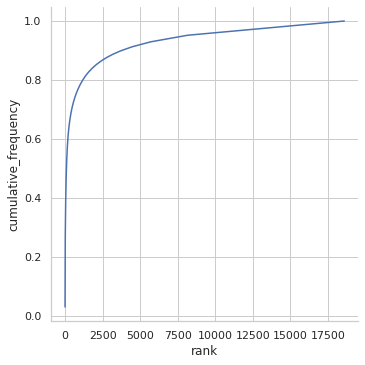

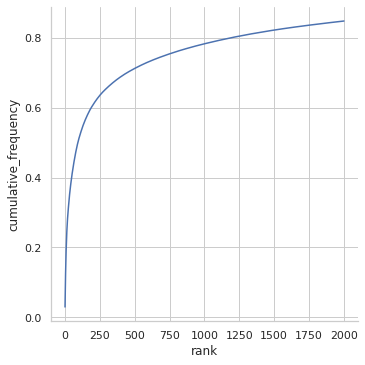

In [25]:
# plots
sns.set_theme(style='whitegrid')

# Plot: Cumulative frequency by index
sns.relplot(x='rank', y='cumulative_frequency', data=VOCABULARY['hate'], kind='line')
sns.relplot(x='rank', y='cumulative_frequency', data=VOCABULARY['hate'][:2000], kind='line') # Cumulative frequency by index, top 10000 tokens

# Plot: Log-log plot for Zipf's law
#frq['log_frq'] = numpy.log(frq.frequency)
#frq['log_rank'] = numpy.log(frq.frequency.rank(ascending=True))
#seaborn.relp

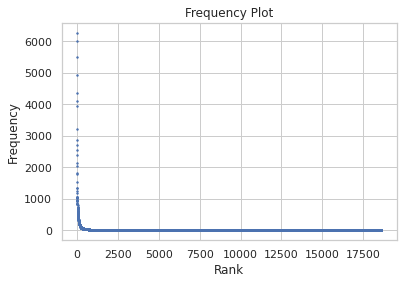

In [26]:
# frequency plot (rank/ frequency)
fig, ax = plt.subplots()
ax.scatter(VOCABULARY['hate']['rank'], VOCABULARY['hate']['frequency'],  s=2);
ax.set_title('Frequency Plot'); ax.set_xlabel('Rank'); ax.set_ylabel('Frequency');

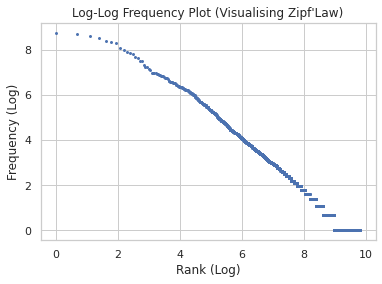

In [27]:
# log-log plot for zipf's law
fig, ax = plt.subplots()
plt.scatter(np.log(VOCABULARY['hate']['rank']), np.log(VOCABULARY['hate']['frequency']), s=15,marker=".")
ax.set_title("Log-Log Frequency Plot (Visualising Zipf'Law)"); ax.set_xlabel('Rank (Log)'); ax.set_ylabel('Frequency (Log)');

## Emotional Plots

In [28]:
one_occurance=VOCABULARY['hate']['frequency']==1

In [29]:
#VOCABULARY['hate'][one_occurance]

*TASK 2*
# XXX
---

In [30]:
# some code

## Exercise 2

In [31]:
from nltk.util import bigrams
list(bigrams(DATA['processed']["emotion"]["train_text"][0]))

[('“', 'worry'),
 ('worry', 'is'),
 ('is', 'a'),
 ('a', 'down'),
 ('down', 'payment'),
 ('payment', 'on'),
 ('on', 'a'),
 ('a', 'problem'),
 ('problem', 'you'),
 ('you', 'may'),
 ('may', 'never'),
 ('never', 'have'),
 ('have', "'"),
 ("'", '.'),
 ('.', 'joyce'),
 ('joyce', 'meyer'),
 ('meyer', '.'),
 ('.', '#motivation'),
 ('#motivation', '#leadership'),
 ('#leadership', '#worry')]

In [32]:
#Adds A <s> to before the first word to indicate that it's the start and an </s> to the end the word to do it
from nltk.util import pad_sequence
list(pad_sequence(DATA['processed']["emotion"]["train_text"][0],
pad_left=True,
left_pad_symbol="<s>",
pad_right=True,
right_pad_symbol="</s>",
n=2))

['<s>',
 '“',
 'worry',
 'is',
 'a',
 'down',
 'payment',
 'on',
 'a',
 'problem',
 'you',
 'may',
 'never',
 'have',
 "'",
 '.',
 'joyce',
 'meyer',
 '.',
 '#motivation',
 '#leadership',
 '#worry',
 '</s>']

In [33]:
from nltk.lm.preprocessing import pad_both_ends
list(pad_both_ends(DATA['processed']["emotion"]["train_text"][0], n=2))

['<s>',
 '“',
 'worry',
 'is',
 'a',
 'down',
 'payment',
 'on',
 'a',
 'problem',
 'you',
 'may',
 'never',
 'have',
 "'",
 '.',
 'joyce',
 'meyer',
 '.',
 '#motivation',
 '#leadership',
 '#worry',
 '</s>']

In [34]:
list(bigrams(pad_both_ends(DATA['processed']["emotion"]["train_text"][0], n=2)))

[('<s>', '“'),
 ('“', 'worry'),
 ('worry', 'is'),
 ('is', 'a'),
 ('a', 'down'),
 ('down', 'payment'),
 ('payment', 'on'),
 ('on', 'a'),
 ('a', 'problem'),
 ('problem', 'you'),
 ('you', 'may'),
 ('may', 'never'),
 ('never', 'have'),
 ('have', "'"),
 ("'", '.'),
 ('.', 'joyce'),
 ('joyce', 'meyer'),
 ('meyer', '.'),
 ('.', '#motivation'),
 ('#motivation', '#leadership'),
 ('#leadership', '#worry'),
 ('#worry', '</s>')]

In [35]:
from nltk.lm.preprocessing import flatten
list(flatten(pad_both_ends(sent, n=2) for sent in DATA['processed']["emotion"]["train_text"][:100]))

['<s>',
 '“',
 'worry',
 'is',
 'a',
 'down',
 'payment',
 'on',
 'a',
 'problem',
 'you',
 'may',
 'never',
 'have',
 "'",
 '.',
 'joyce',
 'meyer',
 '.',
 '#motivation',
 '#leadership',
 '#worry',
 '</s>',
 '<s>',
 'my',
 'roommate',
 ':',
 'it',
 'is',
 'okay',
 'that',
 'we',
 'cannot',
 'spell',
 'because',
 'we',
 'have',
 'autocorrect',
 '.',
 '#terrible',
 '#firstworldprobs',
 '</s>',
 '<s>',
 'no',
 'but',
 'that',
 'is',
 'so',
 'cute',
 '.',
 'atsu',
 'was',
 'probably',
 'shy',
 'about',
 'photos',
 'before',
 'but',
 'cherry',
 'helped',
 'her',
 'out',
 'uwu',
 '</s>',
 '<s>',
 'rooneys',
 'fucking',
 'untouchable',
 'is',
 'not',
 'he',
 '?',
 'been',
 'fucking',
 'dreadful',
 'again',
 ',',
 'depay',
 'has',
 'looked',
 'decent',
 '(',
 'ish',
 ')',
 'tonight',
 '</s>',
 '<s>',
 'it',
 'is',
 'pretty',
 'depressing',
 'when',
 'you',
 'hit',
 'pan',
 'on',
 'ur',
 'favourite',
 'highlighter',
 '</s>',
 '<s>',
 '@user',
 'but',
 'your',
 'pussy',
 'was',
 'weak',
 'from'

In [36]:
from nltk.lm.preprocessing import padded_everygram_pipeline
train, vocab = padded_everygram_pipeline(3, DATA['processed']["hate"]["train_text"])

In [37]:
from nltk.lm import MLE
lm = MLE(5)

In [38]:
len(lm.vocab)

0

In [39]:
lm.fit(train, vocab)
print(lm.vocab)
len(lm.vocab)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 18603 items>


18603

In [40]:
print(lm.counts)

<NgramCounter with 3 ngram orders and 729228 ngrams>


In [41]:
lm.counts[['.']]["</s>"]

1399

In [42]:
lm.score(".", ["</s>"])

0.0

In [43]:
lm.score("randomString")

0.0

In [44]:
 test = [('I', 'am'), ('I', 'hate')]

In [45]:
 lm.entropy(test)

inf

In [46]:
lm.perplexity(test)

inf

"your girlfriend looking at injustices happening in andrew"

'they should understand women cheats on my 16gb of action against their bodies on legs'

#peoplelikemebecause actions. #lovejihad

'betray your hole last weekend me want more' <br>
'hitler may come back'

In [47]:
lm.generate(10, text_seed=["You","are","a","stupid"], random_seed=5)

['fucking', 'idiot', 'hoe', 'i', '’', 've', 'accused', 'him', 'of', 'rape']

In [48]:
from nltk.util import ngrams
text_bigrams = [ngrams(sent, 2) for sent in DATA['processed']["hate"]["train_text"]]
text_unigrams = [ngrams(sent, 1) for sent in DATA['processed']["hate"]["train_text"]]

In [49]:
from nltk.lm import NgramCounter
ngram_counts = NgramCounter(text_bigrams + text_unigrams)

In [50]:
ngram_counts["I"]

414

*TASK 3*
# Manual Annotations and Inter-Annotator Agreement

In this section, we will manually annotate 100 randomly selected tweets from the train corpus in the hate speech data set. We followed the annotation guidelines as employed by the source of the data:

[Final Paper](https://www.aclweb.org/anthology/S19-2007.pdf)

[Annotation Guidelines](https://github.com/msang/hateval/blob/master/annotation_guidelines.md)

In [51]:
GENERATE_SAMPLE = False

In [52]:
if GENERATE_SAMPLE == True:
    with open('../data/annotations/annotation_sample.txt', 'w') as outfile:
        for tweet in DATA['raw']['hate']['train_text'][-100:]: # last 100 tweets in hate training set
            outfile.writelines(tweet + '\n')
    with open('../data/annotations/ground_truth_annotation_sample.txt', 'w') as outfile:
        for label in DATA['raw']['hate']['train_labels'][-100:]:
            outfile.writelines(str(label) + '\n')

In [53]:
# compare manual annotations through building dataframe
annotation_evaluation = pd.DataFrame({'tweets': DATA['raw']['hate']['train_text'][-100:], 'ground_truth': DATA['raw']['hate']['train_labels'][-100:]})

for filename in os.listdir('../data/annotations/manual_annotations'): # opening manually annotated files
    with open(f'../data/annotations/manual_annotations/{filename}', 'r') as infile:
        annotation_evaluation[filename[:-4]] = [int(line.strip()) for line in infile.readlines()]

In [54]:
annotation_evaluation

,tweets,ground_truth,nicola_annotations,hugo_annotations,mika_annotations,aidan_annotations
0,Cry baby Hollywood Dems Anti-Trump celebs too ...,0,0,0,0,0
1,@user Do I have to fight another bitch ass loo...,1,1,0,1,1
2,#SouthCarolina has spent millions of dollars t...,0,0,0,0,0
3,Me trying to flirt- I wanna eat your hot pocket,0,0,0,0,0
4,"People say, ""Why didn't this or that immigrant...",0,0,0,0,0
...,...,...,...,...,...,...
95,Oooohhhh bitch didn't even listen to the dead ...,0,1,0,0,1
96,@user Good Luck @user More Americans #WalkAway...,0,1,0,0,0
97,Bitch you can't keep up so stop trying,1,1,0,1,0
98,@user @user @user @user @user @user Japan is a...,0,0,0,0,0


In [55]:
##compare what tweets were unanimously and un-unanimously annotated
rel_columns=list(annotation_evaluation.columns)
rel_columns.remove('tweets')
rel_columns=annotation_evaluation[rel_columns]
all_true=rel_columns.all(axis=1)
all_false=-rel_columns.any(axis=1)
un_unanimous=annotation_evaluation[-all_true & -all_false]
unanimous=annotation_evaluation[all_true | all_false]
unanimous

,tweets,ground_truth,nicola_annotations,hugo_annotations,mika_annotations,aidan_annotations
0,Cry baby Hollywood Dems Anti-Trump celebs too ...,0,0,0,0,0
2,#SouthCarolina has spent millions of dollars t...,0,0,0,0,0
3,Me trying to flirt- I wanna eat your hot pocket,0,0,0,0,0
4,"People say, ""Why didn't this or that immigrant...",0,0,0,0,0
6,#landdegradation undermines the well-being of ...,0,0,0,0,0
8,Two faced Boris now hes on a power trip dosent...,0,0,0,0,0
10,@user I hope you are not offering them a choic...,1,1,1,1,1
13,I feel like post birth abortion should be a th...,0,0,0,0,0
14,UN countries agree on pact to manage mass glob...,0,0,0,0,0
16,Populists are not anti immigrant or anti immig...,0,0,0,0,0


In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

for person in list(annotation_evaluation)[-4:]:
    print('#'*3 + ' ' + person.replace('_',' ').title() + ' ' + '#'*3)    
    print(pd.DataFrame(confusion_matrix(annotation_evaluation['ground_truth'], annotation_evaluation[person]), columns=['Predicted Non-Hate', 'Predicted Hate'], index=['Non-Hate', 'Hate']))
    print('\n')
    
    print(classification_report(annotation_evaluation['ground_truth'], annotation_evaluation[person], target_names=["Non-Hate","Hate"]))
    print('\n')

### Nicola Annotations ###
          Predicted Non-Hate  Predicted Hate
Non-Hate                  51               6
Hate                       7              36


              precision    recall  f1-score   support

    Non-Hate       0.88      0.89      0.89        57
        Hate       0.86      0.84      0.85        43

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



### Hugo Annotations ###
          Predicted Non-Hate  Predicted Hate
Non-Hate                  57               0
Hate                      28              15


              precision    recall  f1-score   support

    Non-Hate       0.67      1.00      0.80        57
        Hate       1.00      0.35      0.52        43

    accuracy                           0.72       100
   macro avg       0.84      0.67      0.66       100
weighted avg       0.81      0.72      0.68       100



### Mika Annotat

### Cohen's Kappa:

Cohen's kappa can be used to compare each annotator with the original annotations.

Cohen's kappa ranges from -1 to 1, with 1 being a perfect agreement between two classifications.

In [199]:
from sklearn.metrics import cohen_kappa_score

for person in list(annotation_evaluation)[-4:]:
    print(str(person)[:-12] + ":", cohen_kappa_score(annotation_evaluation["ground_truth"], annotation_evaluation[person]))

nicola: 0.7340425531914894
hugo: 0.3791574279379156
mika: 0.70942299709423
aidan: 0.6440536013400335


Nicola has the highest kappa score and Hugo has the least.

Nicola's kappa score of 0.73 is considered as a substantial agreement.

Hugo's kappa score of 0.38 is considered as a fair agreement.

In [ ]:
from scipy.stats import percentileofscore

#percentileofscore()

In [ ]:
from nltk.metrics import AnnotationTask



*TASK 4*
# Automatic Prediction XXX
---

In [57]:
### imports for models, to be moved up later
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from imblearn.over_sampling import RandomOverSampler as ROS

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

from matplotlib.ticker import MaxNLocator

nltk.download('stopwords');

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Models

##### Some helper functions that are used for the model -

In [58]:
def dummy(doc):
    """does nothing"""
    return doc
    
def text_format(dataset, tokenised,tvt="val"):
    """formats the data into a format that is readable by the models, a sparce matrix
    input: dataset should be either "hate" or "emotion", tokenised should be tokenised data. tvt should be "train" if formatting training data """
    cv = CountVectorizer(tokenizer=dummy, preprocessor=dummy) #this sets up the count vectoriser without preprocessing or tokenisation
    cv.fit(DATA["processed"][dataset]["train_text"])#fit to training text(creates empty sparce matrix)
    if tvt=="train":#creates the values in the sparce matrix for the relevant data 
        X_train_counts = cv.transform(DATA["processed"][dataset]["train_text"])
    else:
        X_train_counts = cv.transform(tokenised)        
    return X_train_counts #returns sparce matrix

In [59]:
def remove_stop_uncommon(tokenised,min_frequency,vocab,remove_stop=False):
    """removes stop words and words that occur less than the min frequency in the training data, from tokenised
    inputs:tokenised: tokenised data, min_frequency: integer indicating min frequency of word to be kept,vocab: the vocab of the training data,remove_stop:True/False"""
    stop_words=set()#resets stop_words to an empty set (used if remove_stop = False)
    if remove_stop==True:
        stop_words = set(stopwords.words('english')) #set to downloaded stop word list
    temp_vocab_dict={vocab['index'][x]:vocab['frequency'][x] for x in range(vocab.shape[0])}#creates dictionary of word:frequency for use below
    for token_list in tokenised: #if not in the temp vocab dict then append as 0 to avoid key error
        for token in token_list:
            try: temp_vocab_dict[token]=temp_vocab_dict[token]
            except: temp_vocab_dict[token]= 0
    return [[item for item in list_ if item not in stop_words and temp_vocab_dict[item]>=min_frequency]for list_ in tokenised]#list comprehention that returns a tokenised version with the correct words removed(depending on parameters chosen)

In [60]:
ros_ =ROS(random_state=123)
def fit_model(Classifier,Dataset,min_frequency=1,balance=True,remove_stop_=True):
    """Creates a model
    Inputs:Classifier:"RFC"/"MNB"/"Baseline",Dataset:"emotion"/"hate",min_frequency=1 dont think we will use (could remove parameter),balance and reomve_stop are booleans that determine if data is balanced and if stop words are removed"""
    if balance==True:#balancing the data using RandomOverSampler 
        X, y = ros_.fit_resample(text_format (Dataset,
    remove_stop_uncommon(DATA["processed"][Dataset]["train_text"],min_frequency,VOCABULARY[Dataset],remove_stop=remove_stop_),tvt="train"),
    DATA['processed'][Dataset]['train_labels'])
    else:# set to unbalanced data
        X =text_format (Dataset,remove_stop_uncommon(DATA["processed"][Dataset]["train_text"],min_frequency,VOCABULARY[Dataset],remove_stop=True),tvt="train")
        y = DATA['processed'][Dataset]['train_labels']
    if Classifier=="RFC":##build relevant model
        model = RandomForestClassifier(max_depth=None, n_estimators=100,random_state=0)
    elif Classifier=="MNB":
        model=MultinomialNB(alpha=0.)### this alpha value at its defaut may actually give better results
    elif Classifier=="Baseline":
        model = SGDClassifier(loss='log')
    return model.fit(X,y)#fit the model and return

In [61]:
def model_accuracy_val(min_frequency,Dataset,model,v_or_t="val",remove_stop_=False):
    """takes cleaned and tokensed data and returns accuracy score of the model
    input:min_frequency:int(see remove_stop_uncommon),Dataset:"hate"/"emotion",model:a fitted model,v_or_t:"test" if using test data,remove_stop_:boolean value if val/test should remove stop words"""
    if v_or_t !="val":#warn and set to "test" if v_or_t is changed
        v_or_t="test"
        print("warning! you are using the test data")
    prediction = model.predict(text_format(Dataset,remove_stop_uncommon(DATA["processed"][Dataset][f"{v_or_t}_text"],min_frequency,VOCABULARY[Dataset],remove_stop=remove_stop_),tvt=v_or_t))
    actual = DATA["processed"][Dataset][f"{v_or_t}_labels"]
    return accuracy_score(actual, prediction)#return accuracy score at the given parameters

In [206]:
def model_prf_score(Dataset,min_frequency,model,v_or_t="val",remove_stop__=False):
    """takes cleaned and tokensed data and returns precision, recall and F-score of the model
    inputs:Dataset:"hate"/"emotion",min_frequency:int(see remove_stop_uncommon),model:a fitted model,v_or_t:"test" if using test data,remove_stop_:boolean value if val/test should remove stop words"""
    if v_or_t !="val":#warn and set to "test" if v_or_t is changed
        v_or_t="test"
        print("warning! you are using the test data")
    prediction = model.predict(text_format(Dataset,remove_stop_uncommon(DATA["processed"][Dataset][f"{v_or_t}_text"],min_frequency,VOCABULARY[Dataset],remove_stop=remove_stop__),tvt=v_or_t))
    actual = DATA["processed"][Dataset][f"{v_or_t}_labels"] 
    scores= precision_recall_fscore_support(actual,prediction)#save scores into scores
    order=list(DATA["raw"][Dataset]["mapping"].values())# this gives the labels for the colums and rows of the dataframe
    score_labels=["precision","recall","F-score", "Support"]
    dataframe_of_scores=pd.DataFrame(data=scores,columns=order,index=score_labels)
    list_of_accuracy=[model_accuracy_val(min_frequency,Dataset,model,v_or_t="val",remove_stop_=remove_stop__) for x in range(len(order))]
    dataframe_of_accuracy=pd.DataFrame(data=np.array([list_of_accuracy]), columns=order, index=["Accuracy"])
    #print(dataframe_of_accuracy)

    return pd.concat([dataframe_of_scores,dataframe_of_accuracy])#return pandas df with scores

In [63]:
def plot_accuracy(max_vocab,Dataset,model,ax,remove_stop__=False):
    """plots onto a subplot: the accuracy score of 1 model given validation data with different min_freq values
    input:max_vocab:int shows accuracy in range [0,max_vocab],Dataset:"hate"/"emotion",model:a fitted model,ax:an axis for the sublot e.g.[0,0],remove_stop__:boolean value if val should remove stop words"""
    accuracies=[]
    for i in range (max_vocab):# for each min_freq=i, find accuracy score and append to accuracies
        accuracies.append(model_accuracy_val(i,Dataset,model,remove_stop_=remove_stop__))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))#plot integer values on the xaxis
    ax.plot([x for x in range (max_vocab)],accuracies)
    ax.set_xlabel("Minimum Word Frequecy")
    ax.set_ylabel("Accuracy Score")
    ax.set_title("Accuracy and Minimum Word Frequecy in Validation Data")

In [64]:
def plot_prf_accuracy(Dataset,max_freq,model_list,model_names,v_or_t="val"):
    scores=["Precision","Recall","F-score","Accuracy"]#list of scores here
    if v_or_t !="val":#warn and set to "test" if v_or_t is changed
        v_or_t="test"
        print("warning! you are using the test data")
    num_labels=len(list(DATA["raw"][Dataset]["mapping"].values()))
    fig,ax=plt.subplots(num_labels,4,figsize=(20,3*num_labels))
    fig.tight_layout(pad=0.4, w_pad=1, h_pad=3.0)
    fig.suptitle(f"PRF Scores for {Dataset} {model_names[-1]} Models",y=1.1,fontsize="x-large")
    for x,model in enumerate(model_list):#each column
        #print(model_names[x])
        dataframes=[]
        for i in range(max_freq):
            dataframes.append(model_prf_score(Dataset,i,model))
            #print(dataframes[i])
        for y,label in enumerate(list(DATA["raw"][Dataset]["mapping"].values())):#each row
            ax[y,x].set_title(f"{label.title()} and {model_names[x]}") 
            ax[y,x].set_ylim(0,1)
            ax[y,x].xaxis.set_major_locator(MaxNLocator(integer=True))#plot integer values on the xaxis
            for score in scores:#each line
                y_values=[]
                for i in range(max_freq):
                    value=dataframes[i][label][score]
                    y_values.append(value)
                ax[y,x].plot([x for x in range (max_freq)],y_values,label=score)
    handles, labels = ax[y,x].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right',ncol=3,fontsize="x-large")

#### Code for Hate

In [207]:
MNB_hate=fit_model("MNB","hate",balance=False,remove_stop_=False)
MNB_hate_bal=fit_model("MNB","hate",remove_stop_=False)
MNB_hate_stop=fit_model("MNB","hate",balance=False)
MNB_hate_bal_stop=fit_model("MNB","hate")

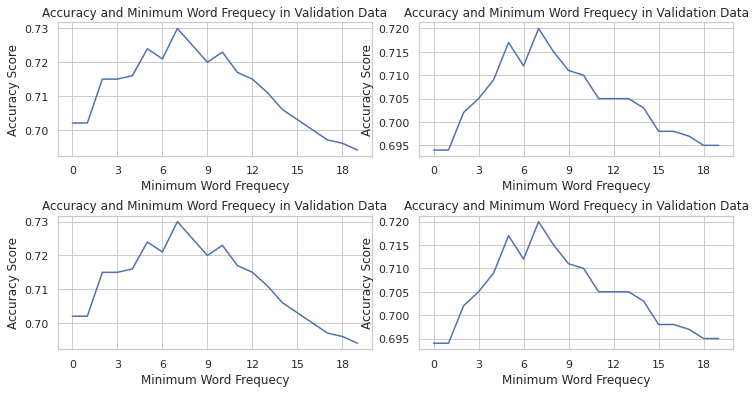

In [66]:
#takes a while to run be here we see that a min freq val of 7/8 is best, this also holds up to 100 and we can assume it holds above 100
fig,ax= plt.subplots(2,2,figsize=(10,5))
fig.tight_layout(pad=0.4, w_pad=1, h_pad=3.0)
frequency=20
plot_accuracy(frequency,"hate",MNB_hate,ax=ax[0,0])
plot_accuracy(frequency,"hate",MNB_hate_bal,ax=ax[0,1])
plot_accuracy(frequency,"hate",MNB_hate_stop,ax=ax[1,0])
plot_accuracy(frequency,"hate",MNB_hate_bal_stop,ax=ax[1,1])

In [205]:
model_prf_score('hate',7,MNB_hate_bal)## use best model here later

[[0.72]
 [0.72]]


,not-hate,hate
precision,0.812367,0.638418
recall,0.664921,0.793911
F-score,0.731286,0.707724
Support,573.000000,427.000000
Accuracy,0.720000,0.720000


In [208]:
model_prf_score("hate",7,MNB_hate,remove_stop__=False)

,not-hate,hate
precision,0.808554,0.654224
recall,0.692845,0.779859
F-score,0.746241,0.711538
Support,573.000000,427.000000
Accuracy,0.730000,0.730000


#### Multiclass Emotions 

In [209]:
MNB_emotion=fit_model("MNB","emotion",balance=False,remove_stop_=False)
MNB_emotion_bal=fit_model("MNB","emotion",remove_stop_=False)
MNB_emotion_stop=fit_model("MNB","emotion",balance=False)
MNB_emotion_bal_stop=fit_model("MNB","emotion")

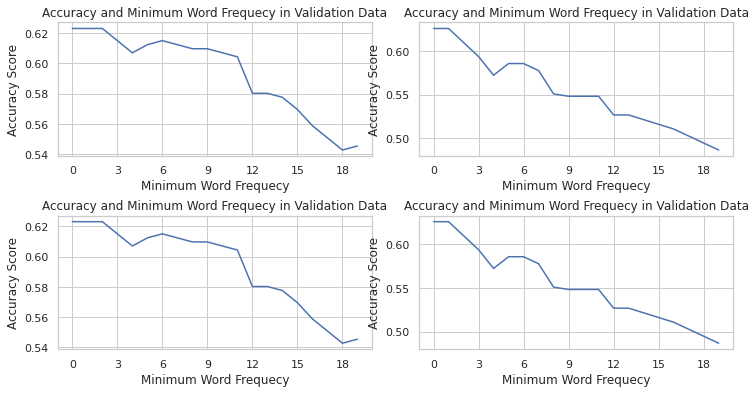

In [ ]:
fig,ax= plt.subplots(2,2,figsize=(10,5))
fig.tight_layout(pad=0.4, w_pad=1, h_pad=3.0)
frequency=20
plot_accuracy(frequency,"emotion",MNB_emotion,ax=ax[0,0])
plot_accuracy(frequency,"emotion",MNB_emotion_bal,ax=ax[0,1])
plot_accuracy(frequency,"emotion",MNB_emotion_stop,ax=ax[1,0])
plot_accuracy(frequency,"emotion",MNB_emotion_bal_stop,ax=ax[1,1])

In [210]:
model_prf_score("emotion",1,MNB_emotion_bal)

,anger,joy,optimism,sadness
precision,0.686813,0.632911,0.350000,0.559140
recall,0.781250,0.515464,0.250000,0.584270
F-score,0.730994,0.568182,0.291667,0.571429
Support,160.000000,97.000000,28.000000,89.000000
Accuracy,0.625668,0.625668,0.625668,0.625668


In [ ]:
prediction = MNB_emotion_bal.predict(text_format("emotion",remove_stop_uncommon(DATA["processed"]["emotion"]["val_text"],1,VOCABULARY["emotion"]),tvt="val"))
actual = DATA["processed"]["emotion"]["val_labels"]

In [ ]:
confusion_matrix(actual,prediction, labels=None, sample_weight=None, normalize=None)

array([[125,  16,   2,  17],
       [ 24,  50,   6,  17],
       [ 10,   4,   7,   7],
       [ 23,   9,   5,  52]])

#### Baseline for hate

In [ ]:
Baseline_hate=fit_model("Baseline","hate",balance=False,remove_stop_=False)
Baseline_hate_bal=fit_model("Baseline","hate",remove_stop_=False)
Baseline_hate_stop=fit_model("Baseline","hate",balance=False)
Baseline_hate_bal_stop=fit_model("Baseline","hate")

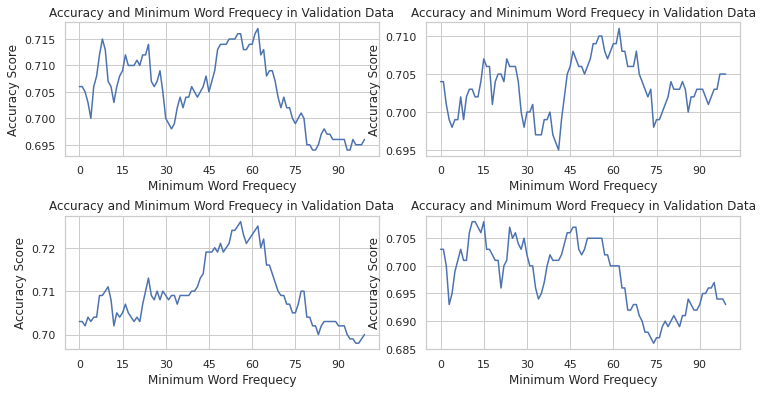

In [ ]:
fig,ax= plt.subplots(2,2,figsize=(10,5))
fig.tight_layout(pad=0.4, w_pad=1, h_pad=3.0)
frequency=100
plot_accuracy(frequency,"hate",Baseline_hate,ax=ax[0,0])
plot_accuracy(frequency,"hate",Baseline_hate_bal,ax=ax[0,1])
plot_accuracy(frequency,"hate",Baseline_hate_stop,ax=ax[1,0])
plot_accuracy(frequency,"hate",Baseline_hate_bal_stop,ax=ax[1,1])

In [ ]:
#model_prf_score("hate",24,baseline) do later

#### Baseline for Emotion

In [211]:
Baseline_emotion=fit_model("Baseline","emotion",balance=False,remove_stop_=False)
Baseline_emotion_bal=fit_model("Baseline","emotion",remove_stop_=False)
Baseline_emotion_stop=fit_model("Baseline","emotion",balance=False)
Baseline_emotion_bal_stop=fit_model("Baseline","emotion")

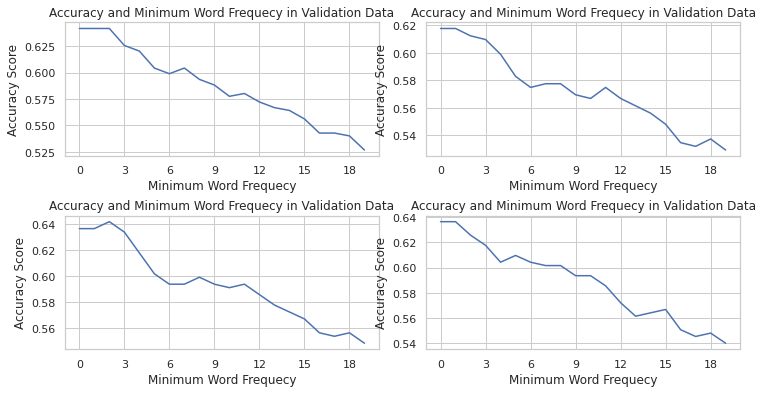

In [ ]:
fig,ax= plt.subplots(2,2,figsize=(10,5))
fig.tight_layout(pad=0.4, w_pad=1, h_pad=3.0)
frequency=20
plot_accuracy(frequency,"emotion",Baseline_emotion,ax=ax[0,0])
plot_accuracy(frequency,"emotion",Baseline_emotion_bal,ax=ax[0,1])
plot_accuracy(frequency,"emotion",Baseline_emotion_stop,ax=ax[1,0])
plot_accuracy(frequency,"emotion",Baseline_emotion_bal_stop,ax=ax[1,1])

In [ ]:
#model_prf_score("emotion",1,baseline)

### Random Forrest

#### Hate

In [217]:
RFC_hate=fit_model("RFC","hate",balance=False,remove_stop_=False)
RFC_hate_bal=fit_model("RFC","hate",remove_stop_=False)
RFC_hate_stop=fit_model("RFC","hate",balance=False)
RFC_hate_bal_stop=fit_model("RFC","hate")

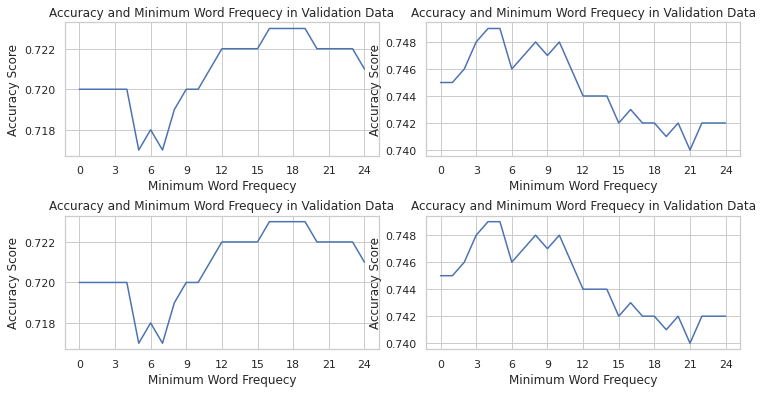

In [ ]:
fig,ax= plt.subplots(2,2,figsize=(10,5))
fig.tight_layout(pad=0.4, w_pad=1, h_pad=3.0)
frequency=25
plot_accuracy(frequency,"hate",RFC_hate,ax=ax[0,0])
plot_accuracy(frequency,"hate",RFC_hate_bal,ax=ax[0,1])
plot_accuracy(frequency,"hate",RFC_hate_stop,ax=ax[1,0])
plot_accuracy(frequency,"hate",RFC_hate_bal_stop,ax=ax[1,1])

In [ ]:
model_prf_score("hate",13,RFC_hate_bal)

,not-hate,hate
precision,0.760263,0.718670
recall,0.808028,0.658080
F-score,0.783418,0.687042
Support,573.000000,427.000000


#### Emotion

In [216]:
RFC_emotion=fit_model("RFC","emotion",balance=False,remove_stop_=False)
RFC_emotion_bal=fit_model("RFC","emotion",remove_stop_=False)
RFC_emotion_stop=fit_model("RFC","emotion",balance=False)
RFC_emotion_bal_stop=fit_model("RFC","emotion")

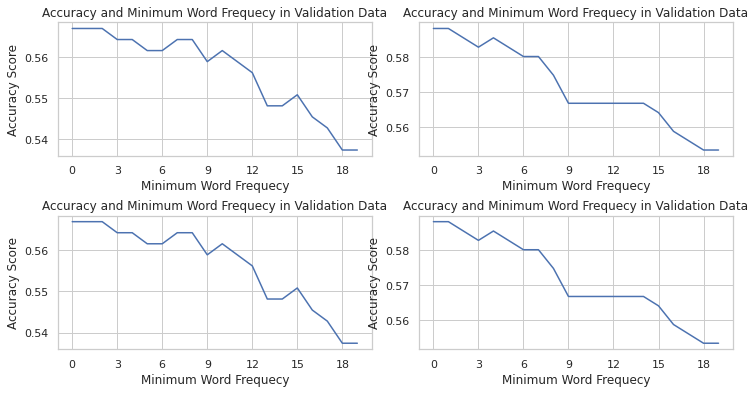

In [ ]:
fig,ax= plt.subplots(2,2,figsize=(10,5))
fig.tight_layout(pad=0.4, w_pad=1, h_pad=3.0)
frequency=20
plot_accuracy(frequency,"emotion",RFC_emotion,ax=ax[0,0])
plot_accuracy(frequency,"emotion",RFC_emotion_bal,ax=ax[0,1])
plot_accuracy(frequency,"emotion",RFC_emotion_stop,ax=ax[1,0])
plot_accuracy(frequency,"emotion",RFC_emotion_bal_stop,ax=ax[1,1])

In [ ]:
model_prf_score("emotion",1,RFC_emotion_bal)#note the big difference here with the optimisim bal vs non bal

,anger,joy,optimism,sadness
precision,0.561475,0.695652,0.500000,0.625000
recall,0.856250,0.329897,0.214286,0.505618
F-score,0.678218,0.447552,0.300000,0.559006
Support,160.000000,97.000000,28.000000,89.000000


# Testing

In [215]:
models=[RFC_emotion,RFC_emotion_bal,RFC_emotion_stop,RFC_emotion_bal_stop]
model_names=["RFC_emotion","RFC_emotion_bal","RFC_emotion_stop","RFC_emotion_bal_stop","Random Forest Classifier"]
plot_prf("emotion",50,models,model_names)

NameError: name 'RFC_emotion' is not defined

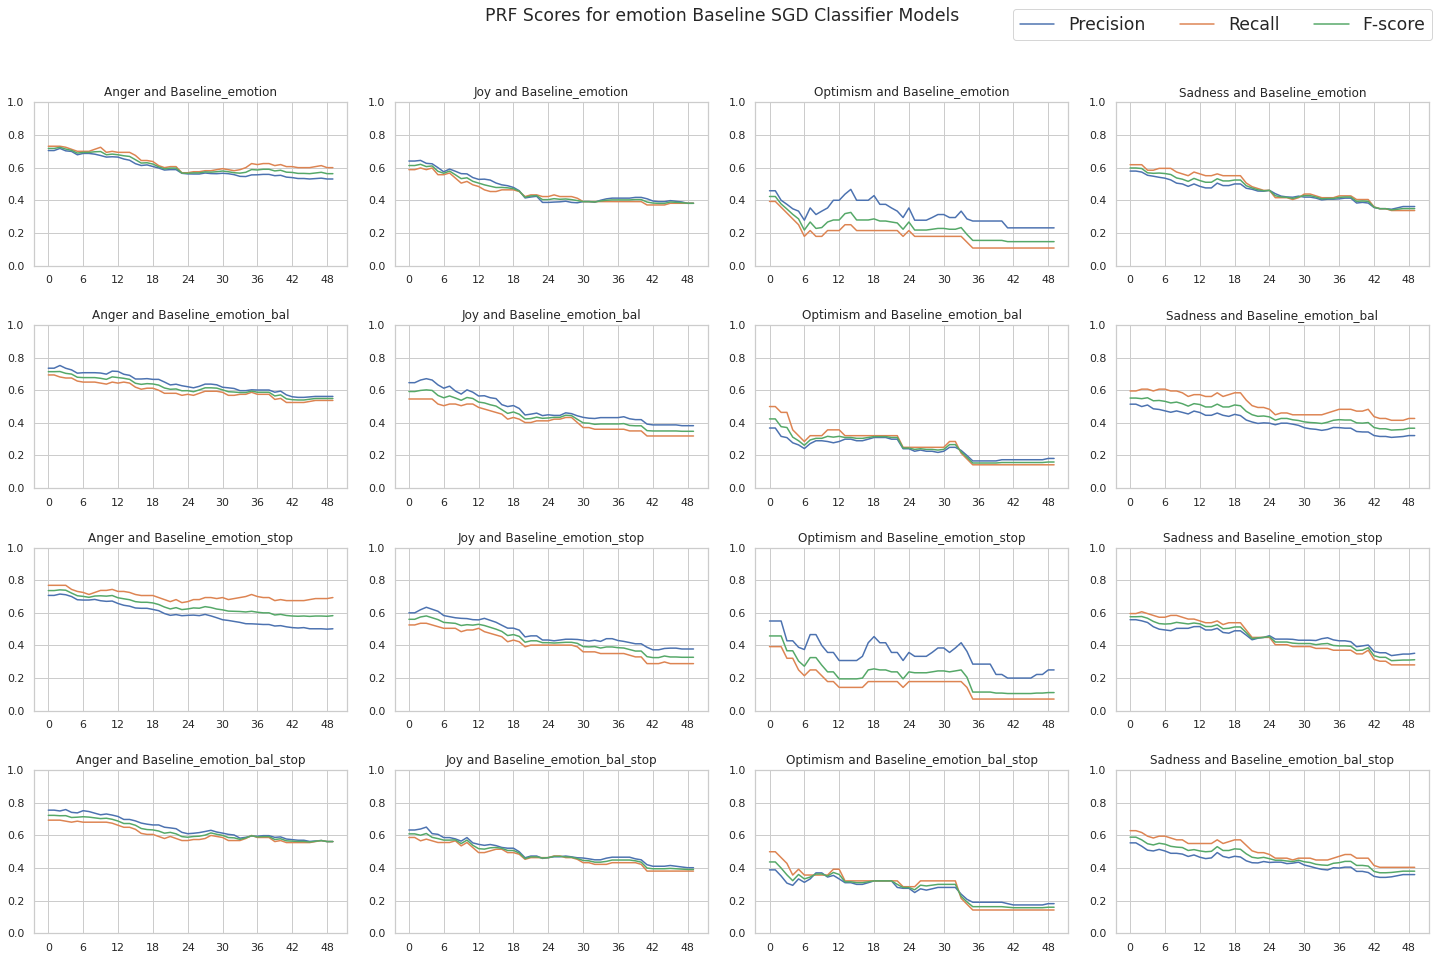

In [ ]:
models=[Baseline_emotion,Baseline_emotion_bal,Baseline_emotion_stop,Baseline_emotion_bal_stop]
model_names=["Baseline_emotion","Baseline_emotion_bal","Baseline_emotion_stop","Baseline_emotion_bal_stop","Baseline SGD Classifier"]
plot_prf("emotion",50,models,model_names)

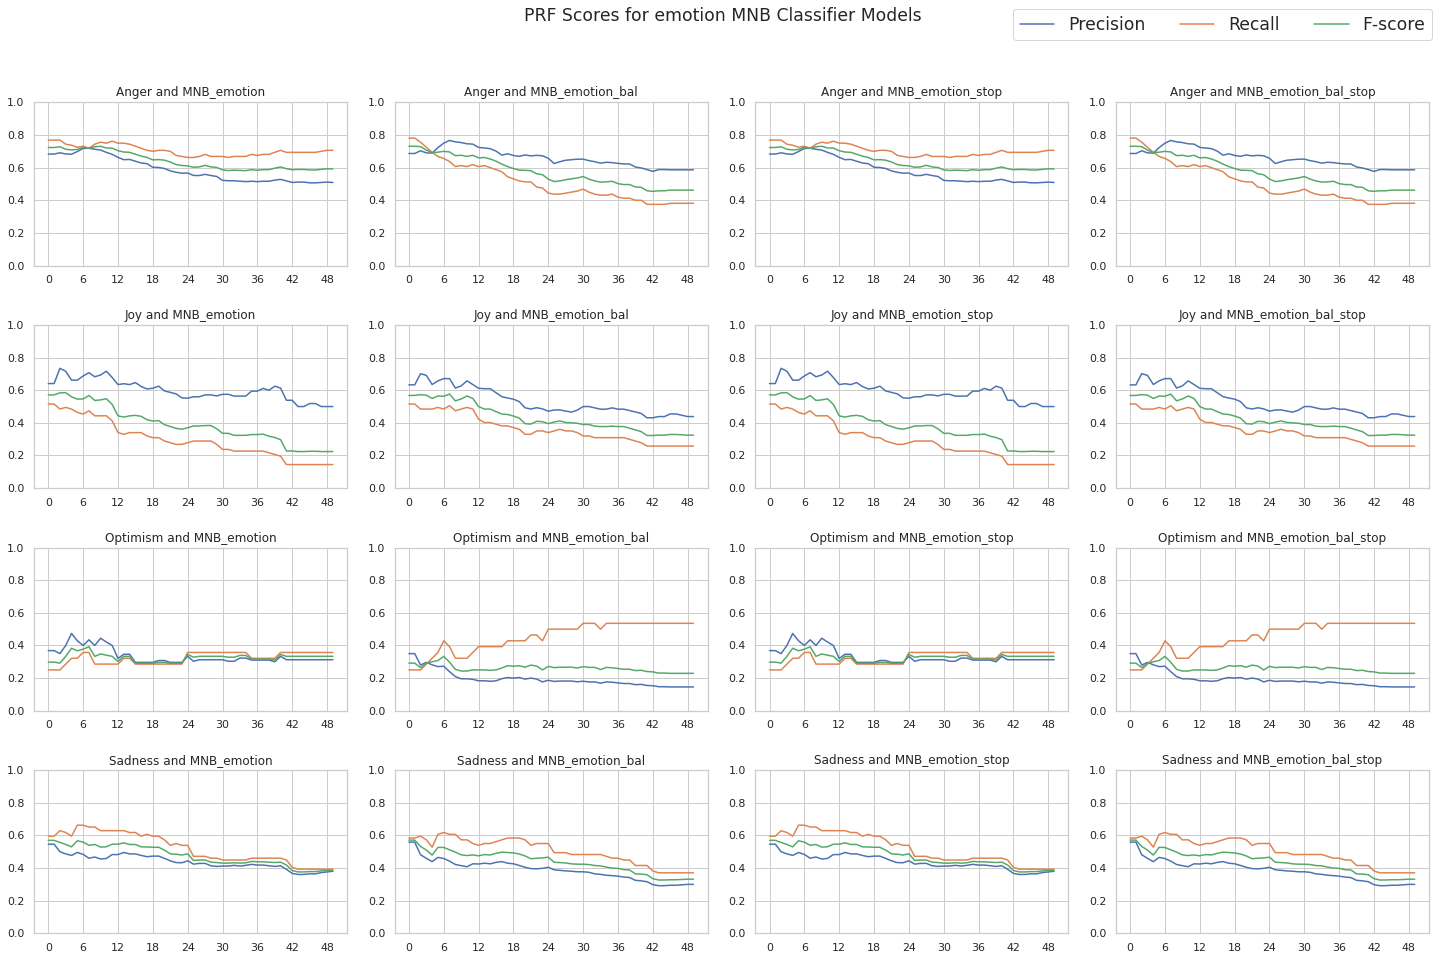

In [ ]:
models=[MNB_emotion,MNB_emotion_bal,MNB_emotion_stop,MNB_emotion_bal_stop]
model_names=["MNB_emotion","MNB_emotion_bal","MNB_emotion_stop","MNB_emotion_bal_stop","MNB Classifier"]
plot_prf("emotion",50,models,model_names)

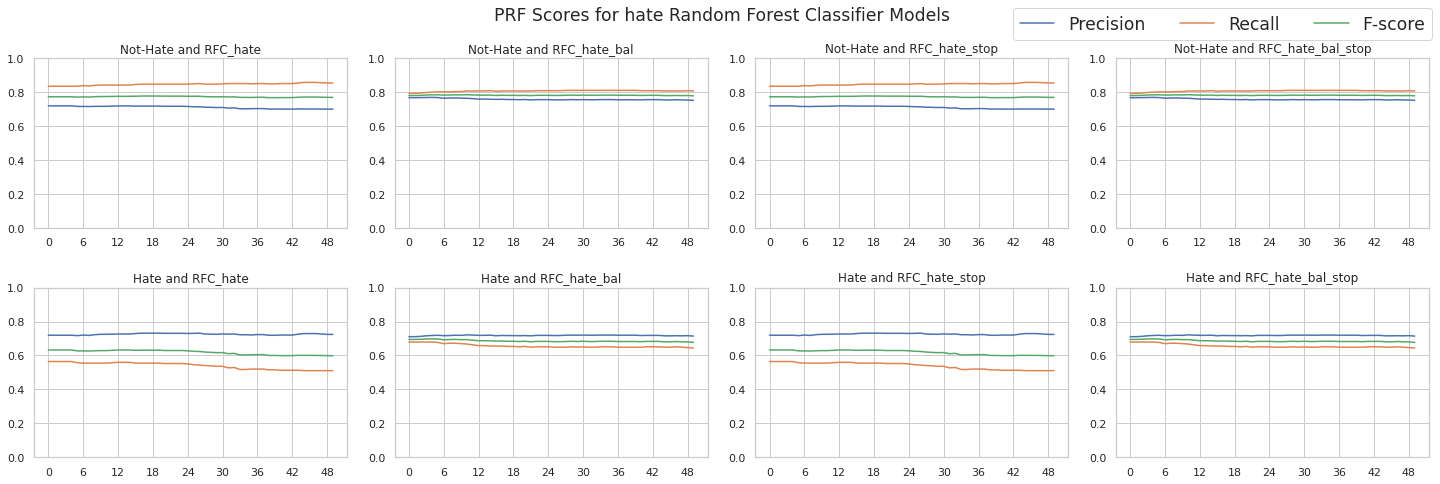

In [ ]:
models=[RFC_hate,RFC_hate_bal,RFC_hate_stop,RFC_hate_bal_stop]
model_names=["RFC_hate","RFC_hate_bal","RFC_hate_stop","RFC_hate_bal_stop","Random Forest Classifier"]
plot_prf("hate",50,models,model_names)

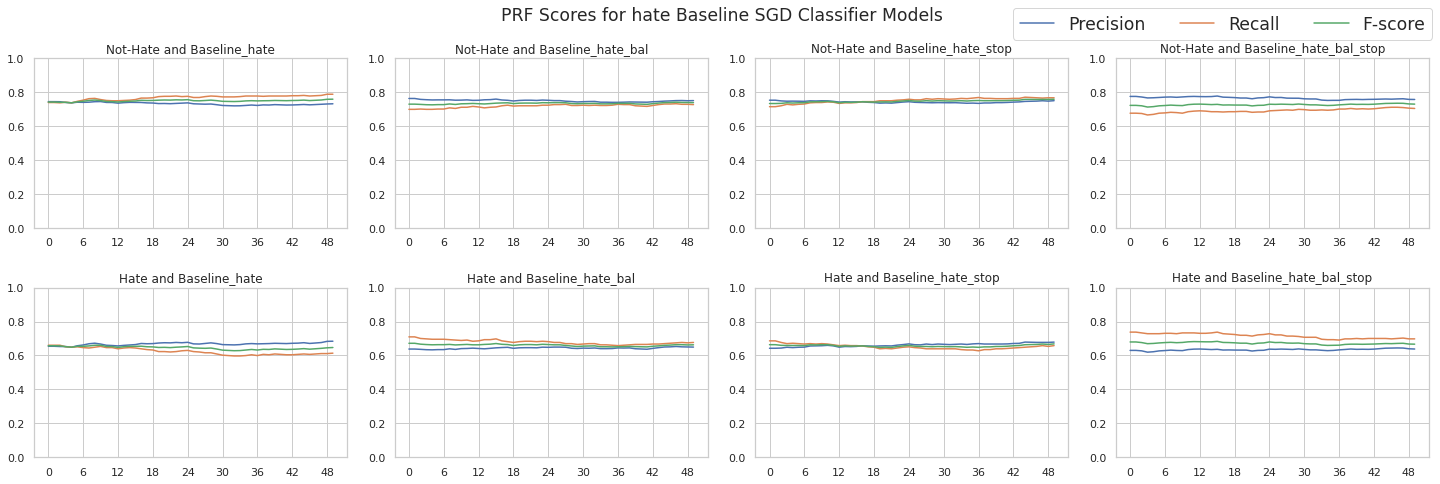

In [ ]:
models=[Baseline_hate,Baseline_hate_bal,Baseline_hate_stop,Baseline_hate_bal_stop]
model_names=["Baseline_hate","Baseline_hate_bal","Baseline_hate_stop","Baseline_hate_bal_stop","Baseline SGD Classifier"]
plot_prf("hate",50,models,model_names)

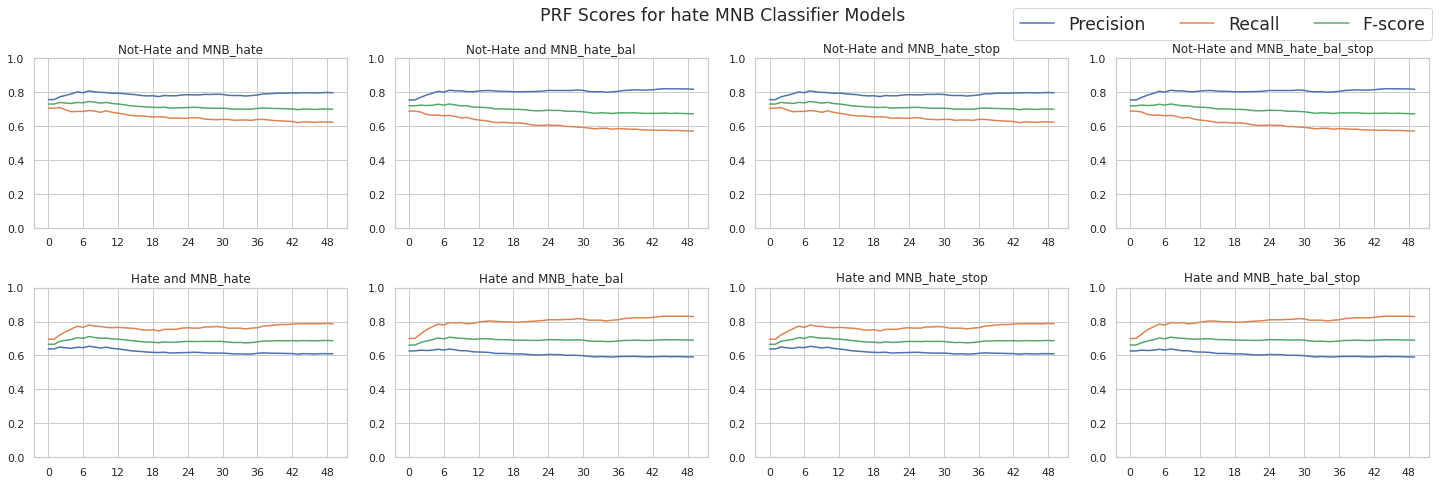

In [ ]:
models=[MNB_hate,MNB_hate_bal,MNB_hate_stop,MNB_hate_bal_stop]
model_names=["MNB_hate","MNB_hate_bal","MNB_hate_stop","MNB_hate_bal_stop","MNB Classifier"]
plot_prf("hate",50,models,model_names)

In [ ]:
model_accuracy_val(10000,"hate",MNB_hate)

0.573

## To Do:
* task 2 descriptive things
* paper 
* make the formatting of the notebook good enough to be readable
* understanding laplace or better estimate instead -smoothing
* improvements to model (4):
- [x] remove min freq
- [x] random forrest
- [x] stopwords (make comparable)
- [x] Multinomial NB model -why and whats different 
* make some graphics to compare values other than accuracy

Nici:
* graph accuracy with other
* summary of graphs
* running with test data
* graphics



important note: if we add a smooting on the multinomialNB by removing the alpha=0. parmeter then the results are better but different. worth looking into as a group, can ammend functions later to accomodate- nicola

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7ea65742-831a-48cd-9d56-a22e1ed66c7b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>